In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [2]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

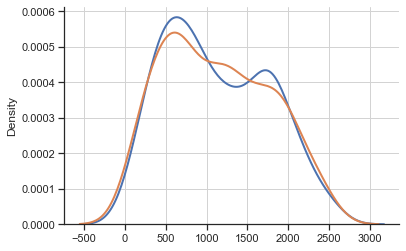

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

In [4]:
X, y, features, categ, sch_nan = ds.load_smarto_dataset()

In [6]:
from survivors.tree import CRAID

custom_params = {"font.size": 16, "axes.labelsize": 16, "xtick.labelsize": 16, "ytick.labelsize": 16,
                 "axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 2, 
     'leaf_model': 'base', 'min_samples_leaf': 0.02, 'signif': 1, 'woe': True}

tree = CRAID(**p)
tree.fit(X, y)

dot = tree.visualize(mode="kde", target="time")
dot
plt.savefig("./CRAID.png")

<Figure size 432x288 with 0 Axes>

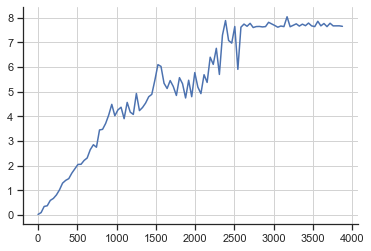

In [22]:
from survivors.tree import CRAID
from survivors.ensemble import ParallelBootstrapCRAID

p = {'balance': None, 'categ': categ, 'criterion': 'wilcoxon', 'cut': False, 'depth': 1, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0,
     'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 1, 'signif': 1, 'woe': True}

ts = []
for s in np.linspace(1, 3873, 100).astype(int):
    time_start = time.time()
    p["depth"] = p_
    tree = CRAID(**p)
    tree.fit(X_tr[:s], y_tr[:s])
    ts.append(time.time() - time_start)
plt.plot(np.linspace(1, 3873, 100).astype(int), ts)

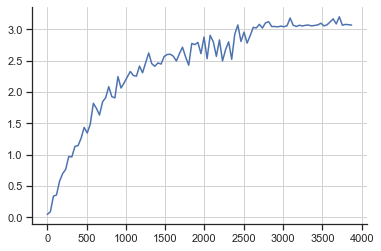

In [21]:
from survivors.tree import CRAID
from survivors.ensemble import ParallelBootstrapCRAID

p = {'balance': None, 'categ': categ, 'criterion': 'wilcoxon', 'cut': False, 'depth': 1, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0,
     'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 1, 'signif': 1, 'woe': True}

ts = []
for s in np.linspace(1, 3873, 100).astype(int):
    time_start = time.time()
    p["depth"] = p_
    tree = CRAID(**p)
    tree.fit(X_tr[:s], y_tr[:s])
    ts.append(time.time() - time_start)
plt.plot(np.linspace(1, 3873, 100).astype(int), ts)

In [4]:
from survivors.tree import CRAID
from survivors.ensemble import ParallelBootstrapCRAID

p = {'balance': None, 'categ': categ, 'criterion': 'wilcoxon', 'cut': False, 'depth': 15, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0,
     'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 0.01, 'n_jobs': 20, 'n_jobs_loop': 1, 'signif': 1, 'woe': True}

time_start = time.time()
tree = CRAID(**p)
tree.fit(X_tr, y_tr)
print(time.time() - time_start)

auprc_by_obs_HO = metr.auprc(y_tr, y_HO, tree.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)
ibsrm_by_obs_HO = metr.ibs_remain(y_tr, y_HO, tree.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)
print(auprc_by_obs_HO)
print(ibsrm_by_obs_HO)

9.821116209030151
[0.99998    0.99998    0.99569204 ... 0.98217849 0.97313351 0.06258666]
[0.00000000e+00 0.00000000e+00 2.08680984e-05 ... 2.79317962e-04
 1.10339743e-03 6.21636290e-01]


In [5]:
dot = tree.visualize(mode="hist", target="time")
dot

### DATASET CHARACTERISTICS DEMONSTRATION

========== GBSG ==========


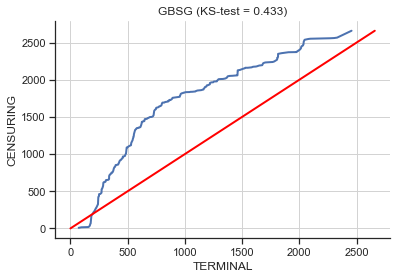

========== PBC ==========


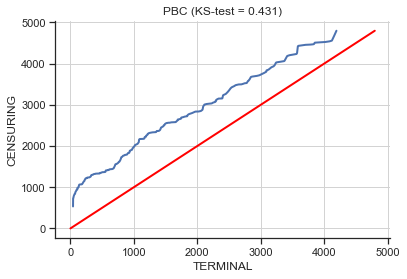

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['max_' + c] = df_agg[c].apply(np.nanmax)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + 

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

========== WUHAN ==========


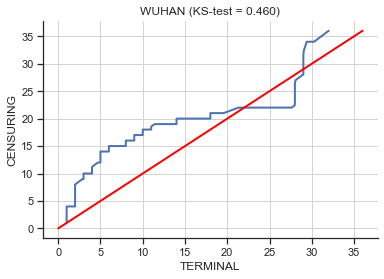

========== smarto ==========


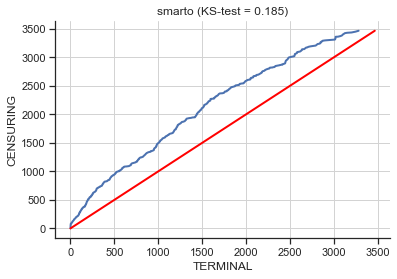

========== rott2 ==========


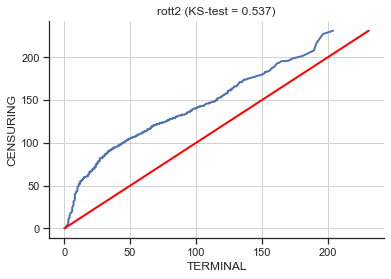

========== support2 ==========


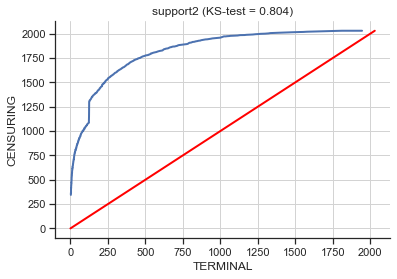

In [13]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

DATASETS_LOAD = {
    "GBSG": ds.load_gbsg_dataset,
    "PBC": ds.load_pbc_dataset,
    "WUHAN": ds.load_wuhan_dataset,
    "smarto": ds.load_smarto_dataset,
    "rott2": ds.load_rott2_dataset,
    "support2": ds.load_support2_dataset
}

def test_normal(sample):
    print("shapiro:", stats.shapiro(sample).pvalue)
    ad = stats.anderson(sample, 'norm')
    print("anderson:", ad.statistic < ad.critical_values[np.where(ad.significance_level == 2.5)][0])
    np.random.seed(42)
    print("kstest:", stats.kstest(sample, 
                       np.random.normal(np.mean(sample), 
                                        np.std(sample), 100000), method="exact").pvalue)

res = pd.DataFrame([], columns=["Dataset", "InfTest", "UnPropSize", "UnPropFeatures"])
for name, loader in DATASETS_LOAD.items():
    X, y, features, categ, sch_nan = loader()
    
    df = X.copy()
    df["time"] = y["time"]
    df["cens"] = y["cens"]
    df = df.fillna(0).replace(np.nan, 0).replace(np.inf, 0)
    print("="*10, name, "="*10)
    #print("TERMINAL")
    #test_normal(df[df["cens"] == 1]["time"])
    #print("CENSURING")
    #test_normal(df[df["cens"] == 0]["time"])
    #print(f'kstest:{stats.kstest(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"]).pvalue:.3e}')
    #print(f'Welch’s t-test:{stats.ttest_ind(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"], equal_var=False).pvalue:.3e}')
    #print(f'mannwhitneyu:{stats.mannwhitneyu(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"]).pvalue:.3e}')
    plt.plot(np.quantile(df[df["cens"] == 1]["time"], np.linspace(0, 1, 1000)),
                np.quantile(df[df["cens"] == 0]["time"], np.linspace(0, 1, 1000)))
    plt.plot([0, df["time"].max()], [0, df["time"].max()], c="red")
    plt.xlabel("TERMINAL")
    plt.ylabel("CENSURING")
    plt.title(f"{name} (KS-test = {stats.kstest(df[df['cens'] == 1]['time'], df[df['cens'] == 0]['time'], method='exact').statistic:.3f})")
    plt.savefig(f"./{name}_qq.png")
    plt.show()

    cph = CoxPHFitter(penalizer=0.000001).fit(df, 'time', 'cens')  # strata=[feat]
    results = proportional_hazard_test(cph, df, time_transform='km')
    unprop_features = {n:p for n, p in zip(results.name, results._p_value) if p < 0.05}
    a = pd.DataFrame([{"Dataset":name, 
                      "InfTest":stats.kstest(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"], method="exact").pvalue,
                      "InfTestStat":stats.kstest(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"], method="exact").statistic,
                      "UnPropSize": len(unprop_features),
                      "UnPropFeatures": dict(sorted(unprop_features.items(), key=lambda item: item[1])[:5])}])
    res = pd.concat([res, a], ignore_index=True)
res.to_csv(os.path.join(f"./Dataset_EDA.csv"), sep="&")

In [8]:
loader.__name__.split("_")[1]

'support2'

In [19]:
stats.kstest(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"], method="exact").statistic

0.4663524482848913

In [201]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

cph = CoxPHFitter(penalizer=0.000001).fit(df, 'time', 'cens')  # strata=[feat]

plt.figure(figsize=(14, 7))
# cph.check_assumptions(df, p_value_threshold=0.1)

results = proportional_hazard_test(cph, df, time_transform='rank')
# results.print_summary(decimals=3, model="untransformed variables")

<Figure size 1008x504 with 0 Axes>

In [215]:
for n, p in zip(results.name, results._p_value):
    if p < 0.05:
        print(f'{n} p-value:{p:.3e}')

num_edu p-value:5.599e-05
num_scoma p-value:1.325e-39
num_sps p-value:3.511e-54
num_surv6m p-value:1.173e-12
num_temp p-value:3.964e-02
num_pafi p-value:2.975e-02
num_crea p-value:4.546e-02
num_ph p-value:1.089e-03
num_urine p-value:2.517e-03
num_adls p-value:1.847e-03
fac_sex p-value:1.138e-06
fac_dzclass p-value:2.284e-04
fac_diabetes p-value:7.276e-03
fac_dementia p-value:1.521e-02
fac_ca p-value:4.519e-03
fac_sfdm2 p-value:3.843e-182


In [66]:
from typing import List, Optional, Dict, Any, Iterable
from textwrap import dedent, fill
from autograd import numpy as anp
import numpy as np
from pandas import DataFrame, Series
from lifelines.statistics import proportional_hazard_test, TimeTransformers
from lifelines.utils import format_p_value
from lifelines.utils.lowess import lowess


def plot_assumptions(cph,
        training_df: DataFrame,
        p_value_threshold: float = 0.01,
        plot_n_bootstraps: int = 15,
        columns: Optional[List[str]] = None):    
    residuals = cph.compute_residuals(training_df, kind="scaled_schoenfeld")
    test_results = proportional_hazard_test(cph, training_df, time_transform=["rank", "km"], precomputed_residuals=residuals)

    residuals_and_duration = residuals.join(training_df[cph.duration_col])
    Xs = cph.regressors.transform_df(training_df)

    counter = 0
    n = residuals_and_duration.shape[0]
    axes = []

    for variable in cph.params_.index.intersection(columns or cph.params_.index):
        minumum_observed_p_value = test_results.summary.loc[variable, "p"].min()
        if np.round(minumum_observed_p_value, 2) > p_value_threshold:
            continue
        counter += 1
        # show plots
        axes.append([])
        fig = plt.figure(figsize=(14, 7))

        # plot variable against all time transformations.
        for i, (transform_name, transformer) in enumerate(TimeTransformers().iter(["rank", "km"]), start=1):
            p_value = test_results.summary.loc[(variable, transform_name), "p"]

            ax = fig.add_subplot(1, 2, i)

            y = residuals_and_duration[variable]
            tt = transformer(cph.durations, cph.event_observed, cph.weights)[cph.event_observed.values]

            ax.scatter(tt, y, alpha=0.75)

            y_lowess = lowess(tt.values, y.values)
            ax.plot(tt, y_lowess, color="k", alpha=1.0, linewidth=2)

            # bootstrap some possible other lowess lines. This is an approximation of the 100% confidence intervals
            for _ in range(plot_n_bootstraps):
                ix = sorted(np.random.choice(n, n))
                tt_ = tt.values[ix]
                y_lowess = lowess(tt_, y.values[ix])
                ax.plot(tt_, y_lowess, color="k", alpha=0.30)

            best_xlim = ax.get_xlim()
            ax.hlines(0, 0, tt.max(), linestyles="dashed", linewidths=1)
            ax.set_xlim(best_xlim)

            ax.set_xlabel("%s-transformed time\n(p=%.4f)" % (transform_name, p_value), fontsize=13)
            axes[-1].append(ax)

        fig.suptitle("Scaled Schoenfeld residuals of '%s'" % variable, fontsize=14)
        plt.tight_layout()
#         plt.subplots_adjust(top=0.90)

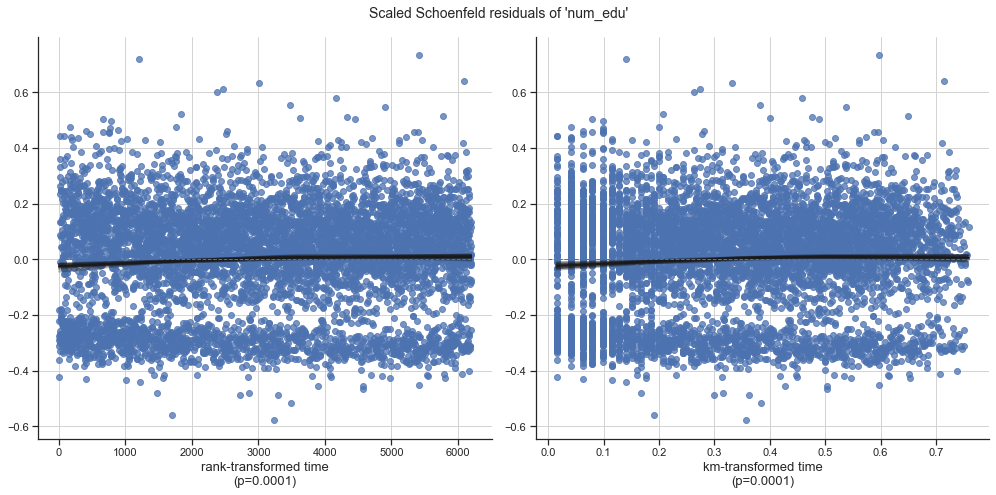

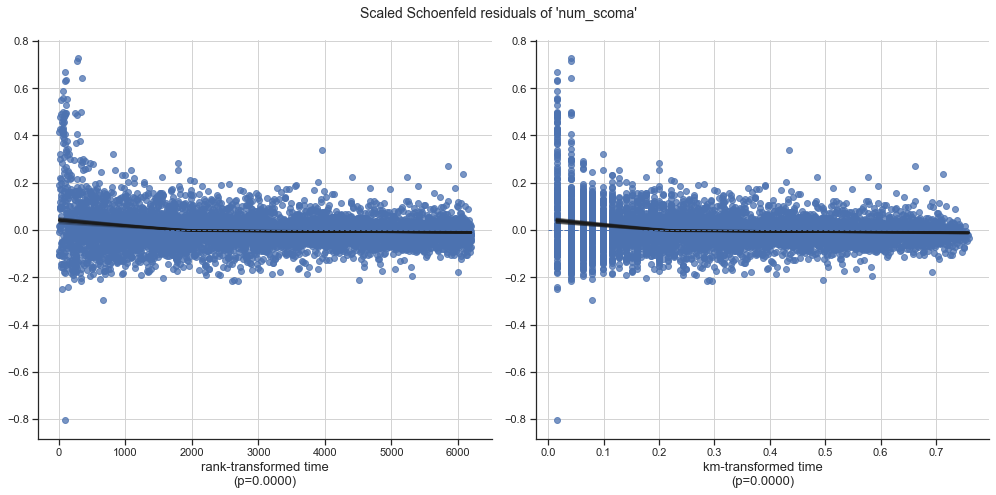

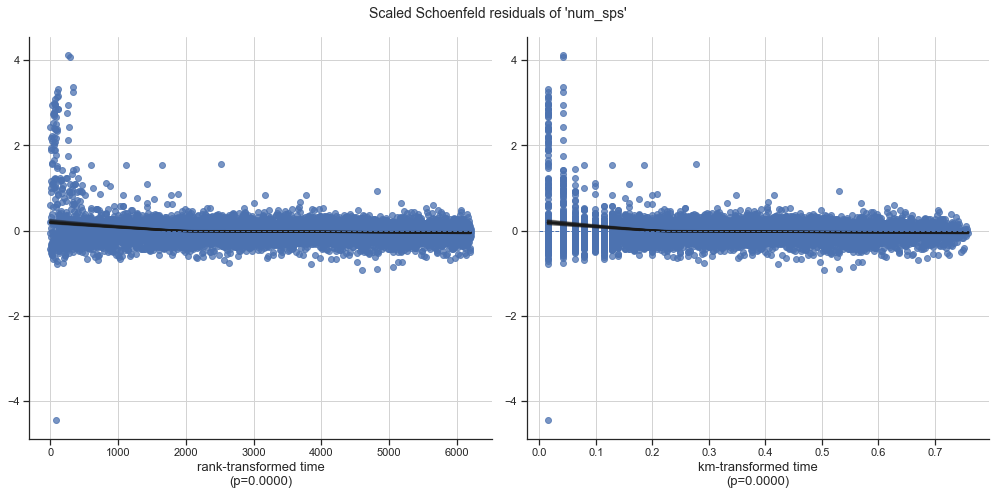

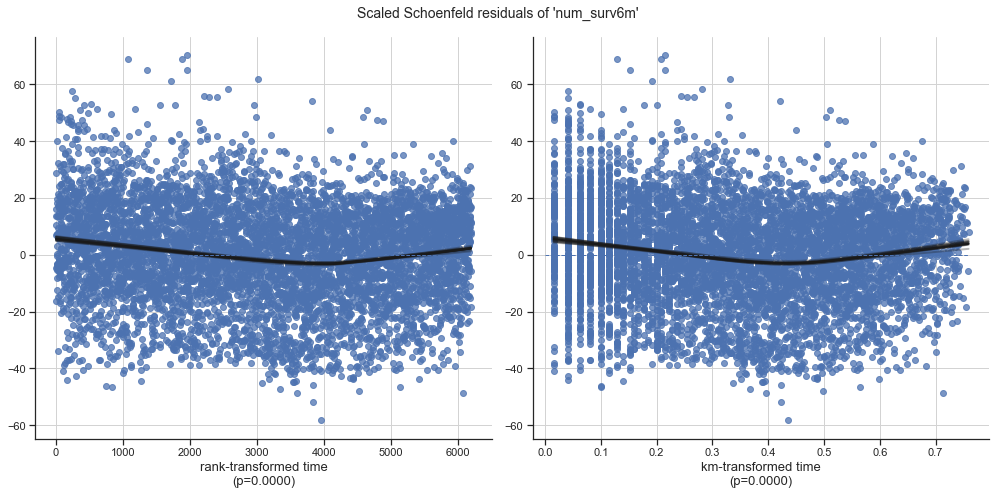

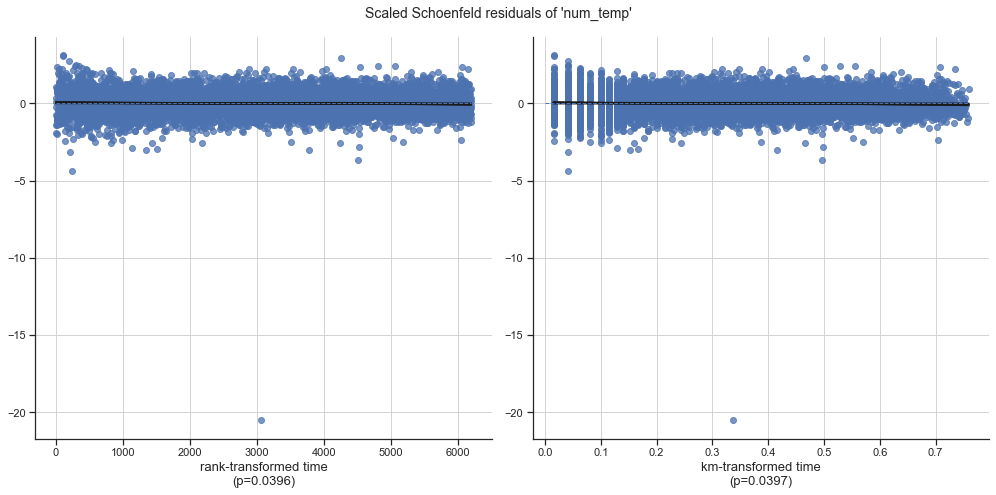

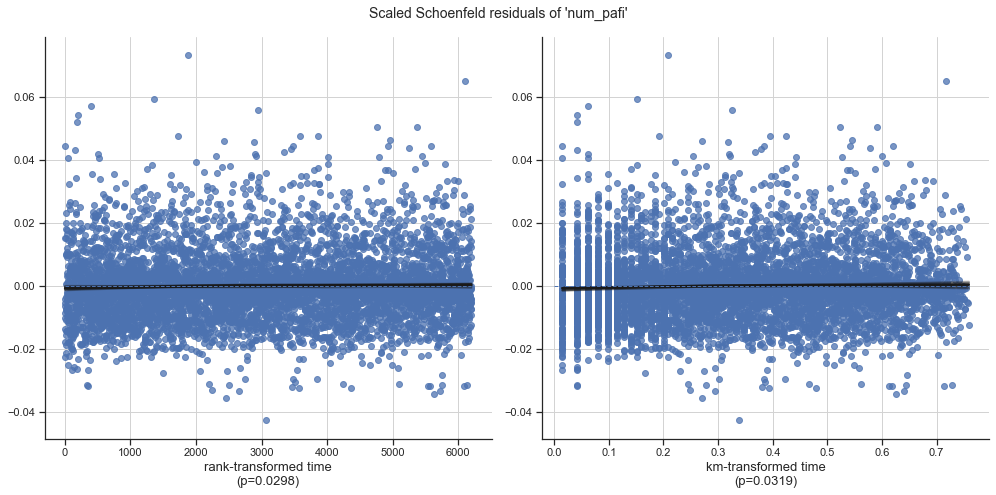

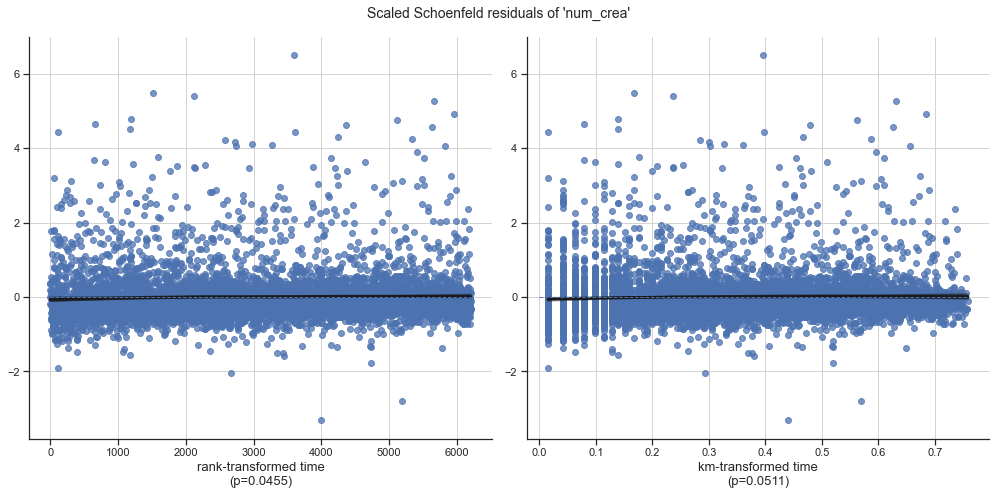

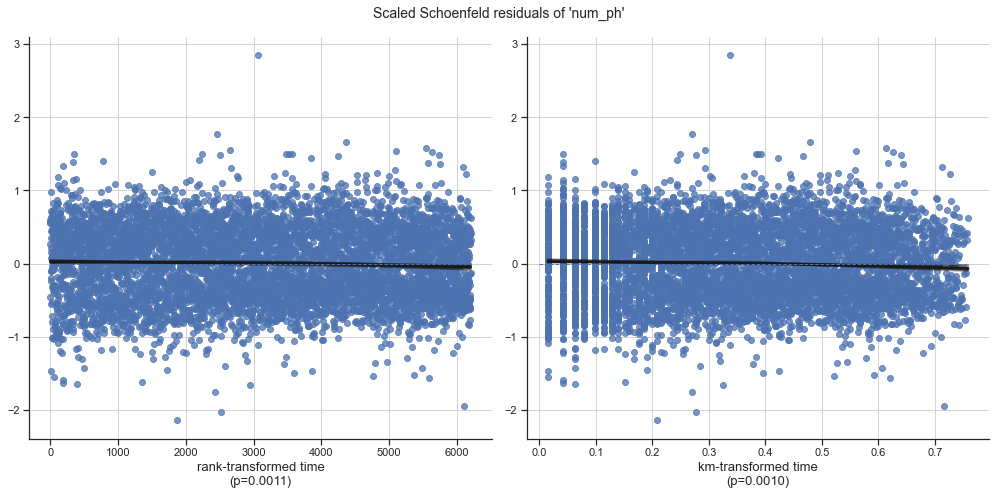

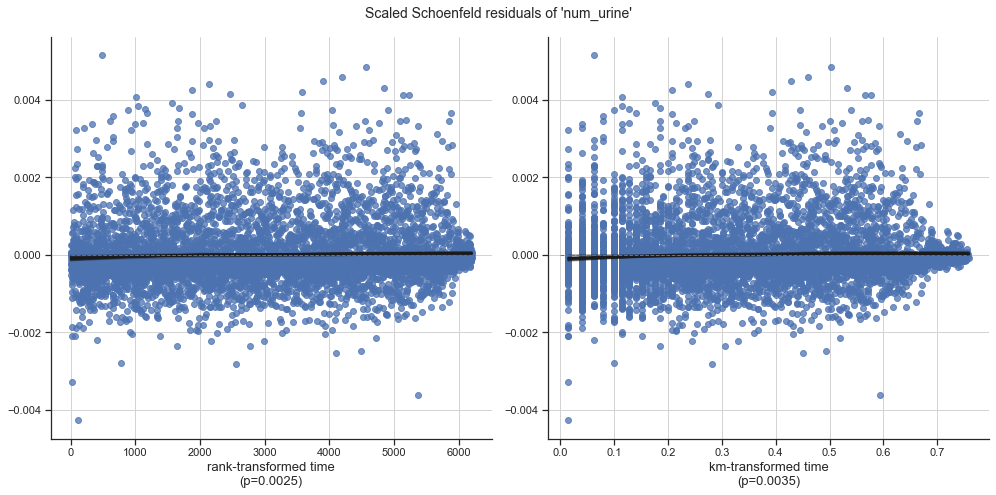

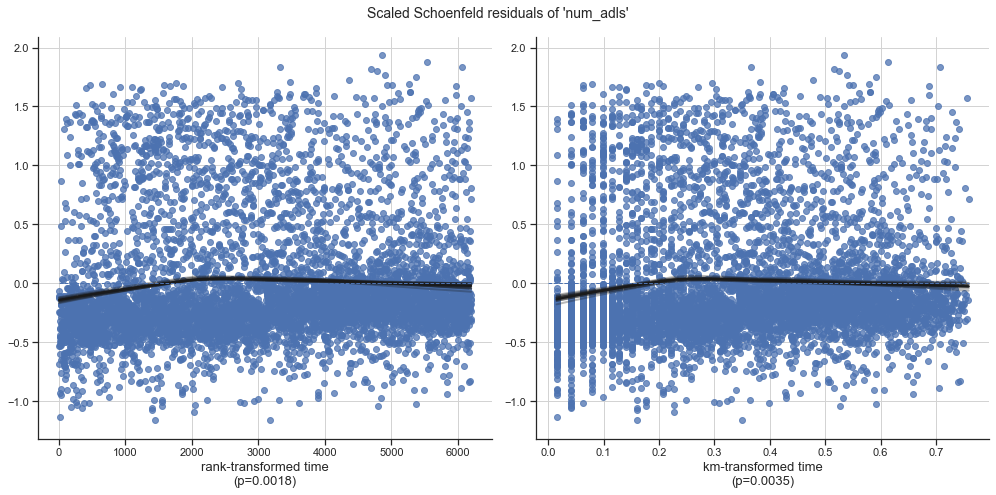

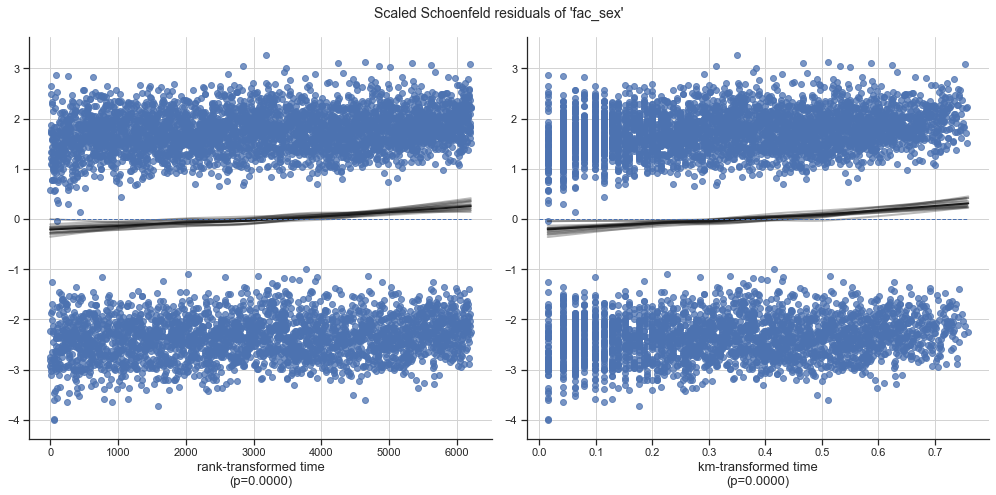

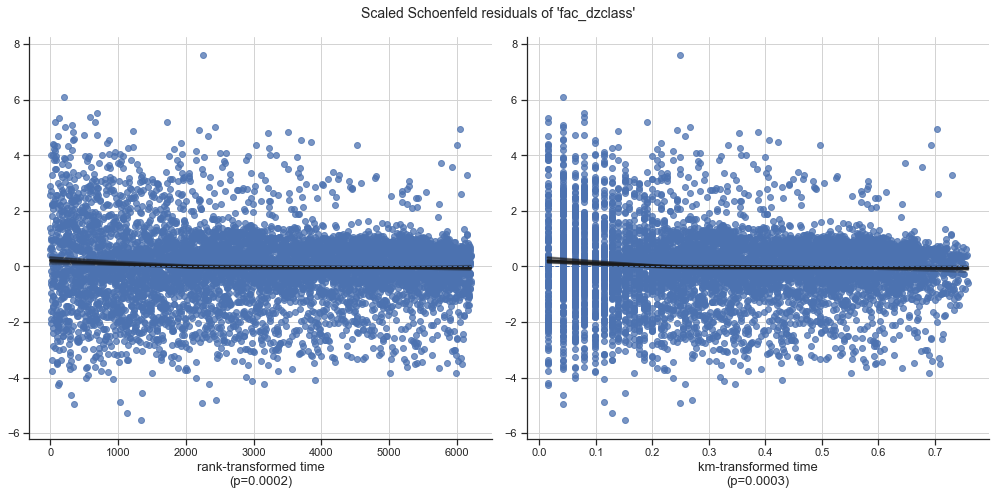

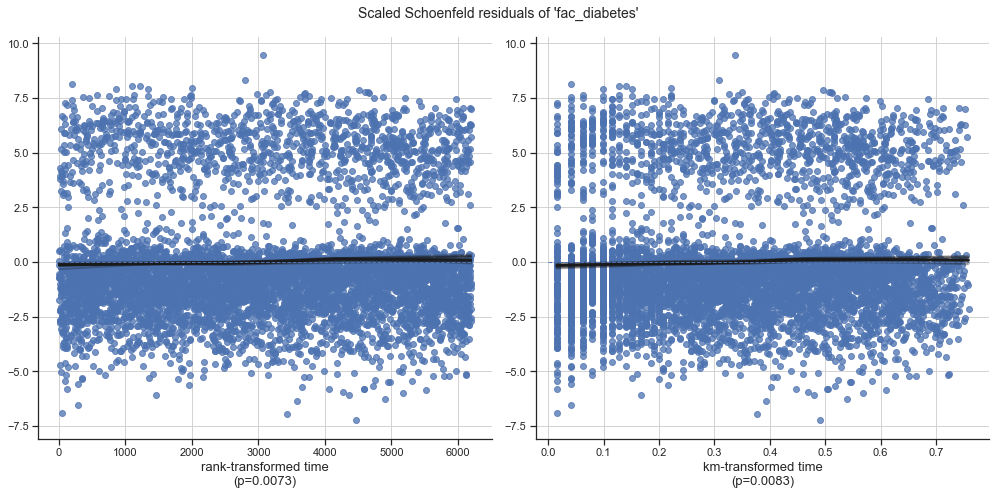

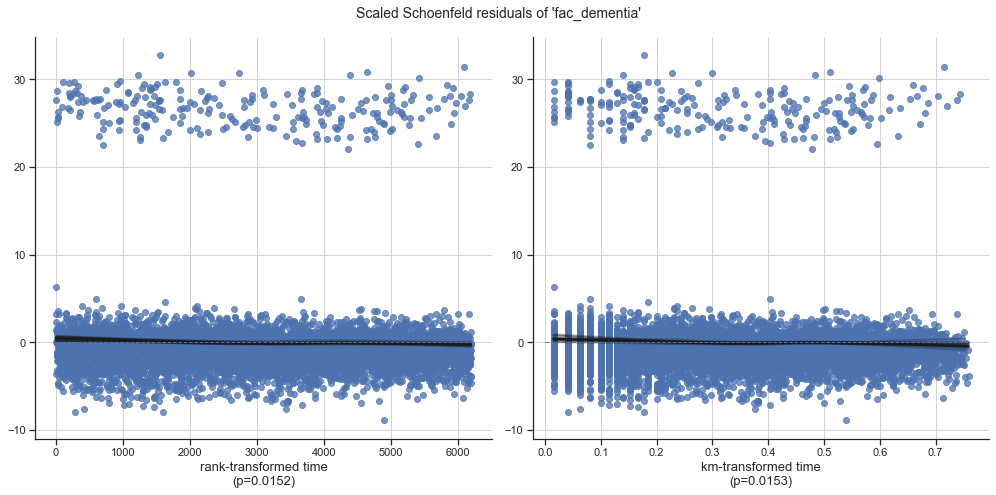

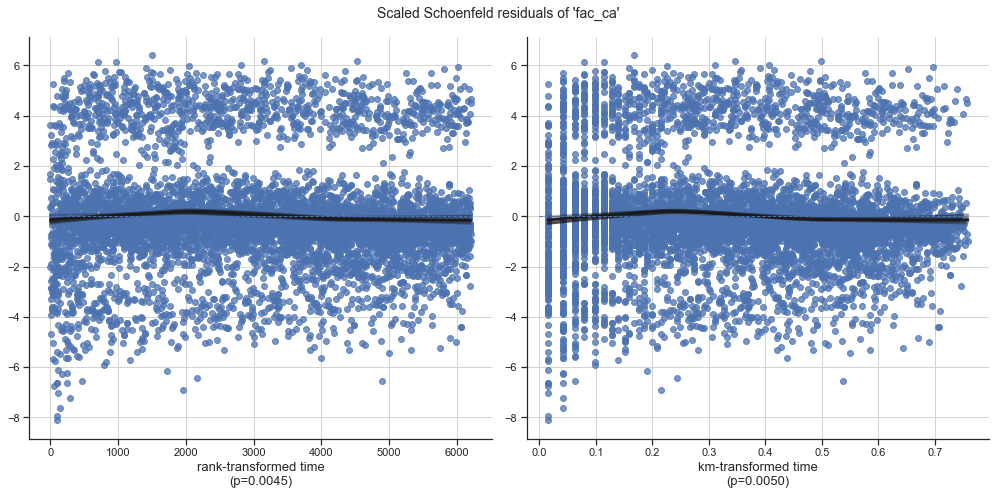

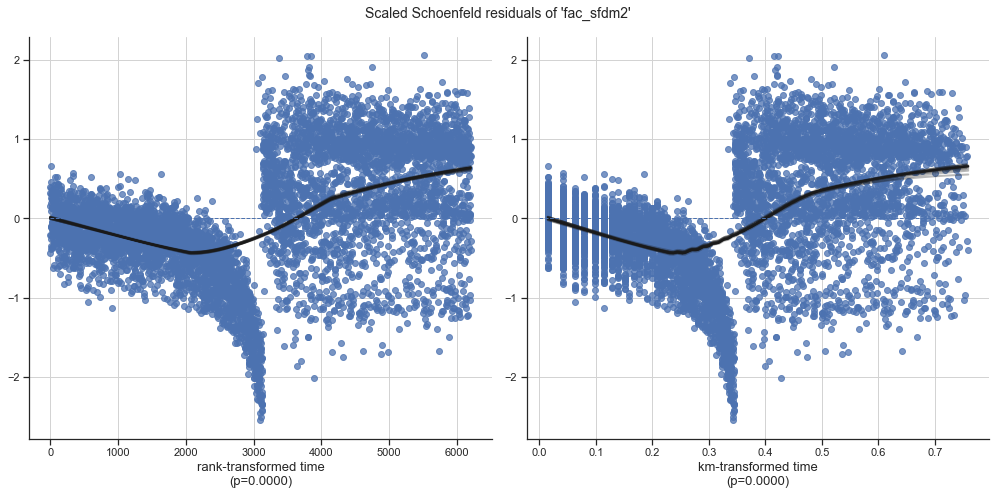

In [67]:
plot_assumptions(cph, df, p_value_threshold=0.05)

KeyError: 'tumgrad'

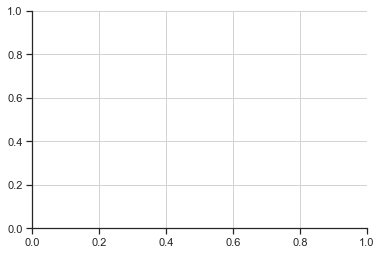

In [47]:
# feat = "menostat"  # GBSG (menostat)
feat = "tumgrad"  # PBC (sex, tumgrad)

bins = np.unique(y["time"])

fig, axs = plt.subplots(figsize=(6, 4))
for v in np.unique(df[feat]):
    index = df.query(f"{feat} == {v}").index
    
    kmf = KaplanMeierFitter()
    kmf.fit(df.loc[index]['time'], event_observed=df.loc[index]['cens'])
    sf_train = kmf.survival_function_at_times(bins).to_numpy()
    plt.plot(bins, sf_train, label=f"{feat}={v}")
plt.ylabel("Вероятность выживания", **axis_font)
plt.xlabel("Время", **axis_font)
plt.legend()

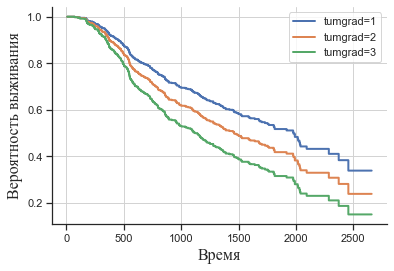

In [25]:
from lifelines import CoxPHFitter
df1 = df[[feat, "time", "cens"]]

cph.plot_partial_effects_on_outcome(feat, plot_baseline=False, 
                                    values=np.unique(X[feat]))
plt.ylabel("Вероятность выживания", **axis_font)
plt.xlabel("Время", **axis_font)
plt.legend()

### CHECK QUALITY IN LEAVES

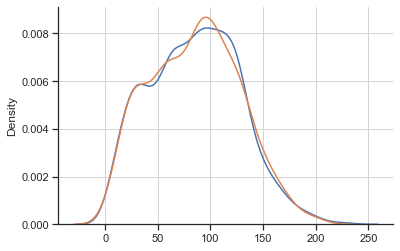

In [166]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_rott2_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

In [173]:
from survivors.tree import CRAID
p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 15, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0,
     'leaf_model': 'base_zero_after', 
     'max_features': 1.0, 'min_samples_leaf': 0.05, 'n_jobs': 1, 'signif': 0.1, 'woe': True}

tree = CRAID(**p)
tree.fit(X_tr, y_tr)

pred_time = tree.predict(X_HO, target="time")
pred_surv = tree.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_surv[:, -1] = 0
pred_surv[:, 0] = 1

pred_surv_tr = tree.predict_at_times(X_tr, bins=bins_HO, mode="surv")
pred_surv_tr[:, -1] = 0
pred_surv_tr[:, 0] = 1
    
pred_haz = tree.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

auprc_by_obs_tr = metr.auprc(y_tr, y_tr, tree.predict_at_times(X_tr, bins=bins_HO, mode="surv"), bins_HO, axis=0)
auprc_by_obs_HO = metr.auprc(y_tr, y_HO, tree.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)

ibsrm_by_obs_tr = metr.ibs_remain(y_tr, y_tr, tree.predict_at_times(X_tr, bins=bins_HO, mode="surv"), bins_HO, axis=0)
ibsrm_by_obs_HO = metr.ibs_remain(y_tr, y_HO, tree.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)

In [171]:
def get_color(a):
    return np.where(a, "blue", "orange")

(num_nodes > 4.5) & (num_progesterone > 48.0)


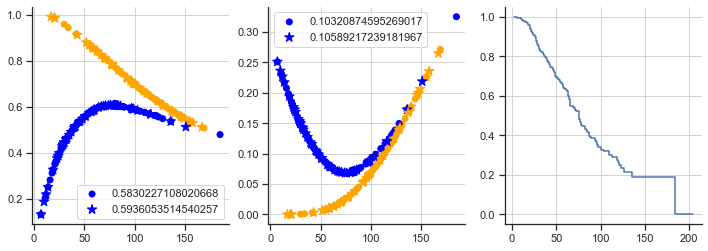

((num_nodes <= 4.5)| nan) & (num_nodes > 1.5) & ((num_estrogen <= 60.0)| nan)


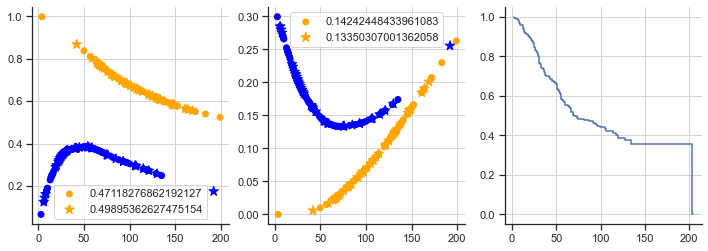

((num_nodes <= 4.5)| nan) & (num_nodes > 1.5) & (num_estrogen > 60.0)


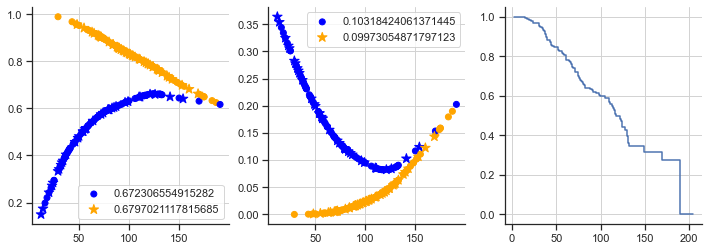

(num_nodes > 4.5) & ((num_progesterone <= 48.0)| nan) & ((num_nodes <= 8.5)| nan)


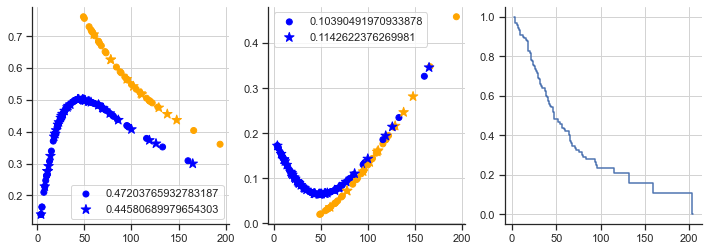

(num_nodes > 4.5) & ((num_progesterone <= 48.0)| nan) & (num_nodes > 8.5)


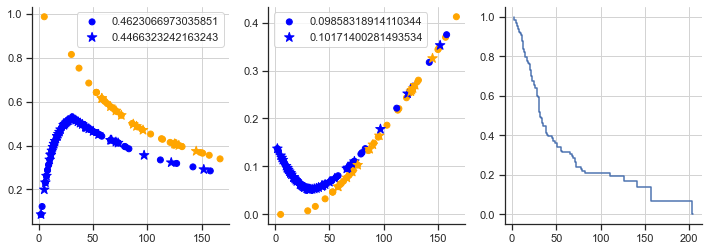

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & (num_age > 66.5) & ((fac_tsize in [0.0])| nan)


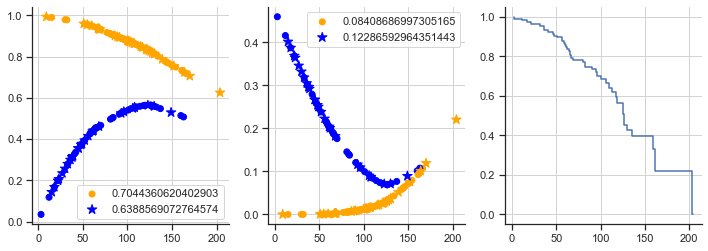

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & (num_age > 66.5) & (fac_tsize in [1.0, 2.0])


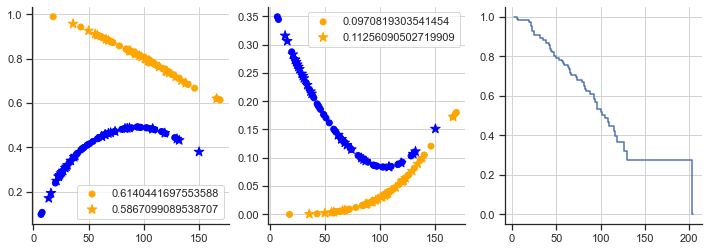

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & ((num_progesterone <= 58.0)| nan) & ((num_year <= 1986.5)| nan)


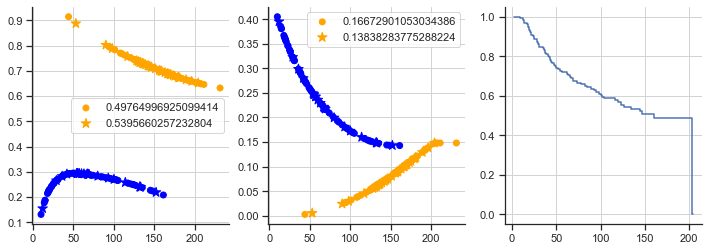

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & (num_progesterone > 58.0) & (fac_tsize in [1.0, 2.0])


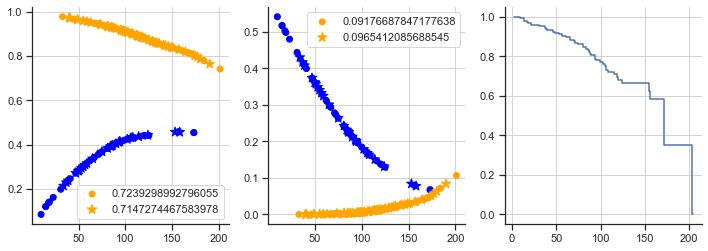

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & ((num_progesterone <= 58.0)| nan) & (num_year > 1986.5) & ((num_age <= 48.5)| nan)


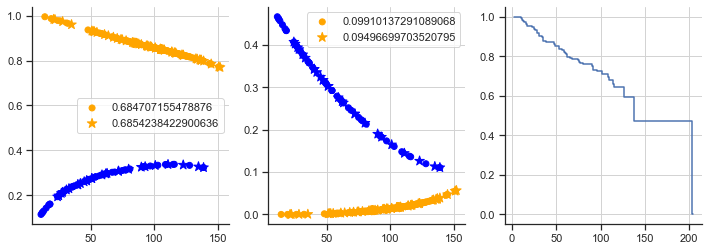

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & (num_progesterone > 58.0) & ((fac_tsize in [0.0])| nan) & ((num_year <= 1988.5)| nan)


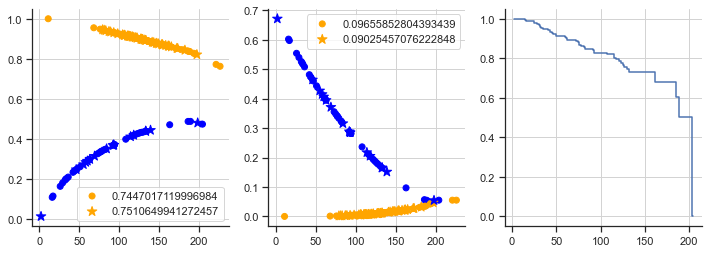

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & (num_progesterone > 58.0) & ((fac_tsize in [0.0])| nan) & (num_year > 1988.5)


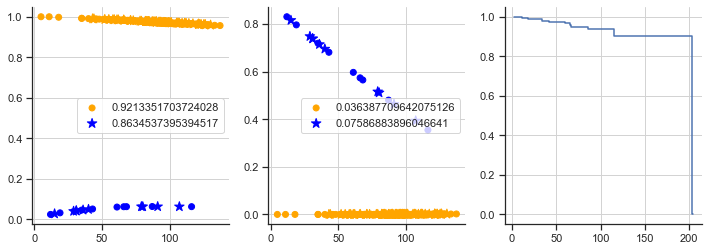

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & ((num_progesterone <= 58.0)| nan) & (num_year > 1986.5) & (num_age > 48.5) & ((num_progesterone <= 4.5)| nan)


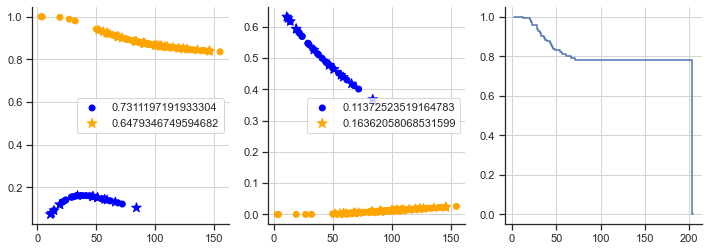

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & ((num_progesterone <= 58.0)| nan) & (num_year > 1986.5) & (num_age > 48.5) & (num_progesterone > 4.5)


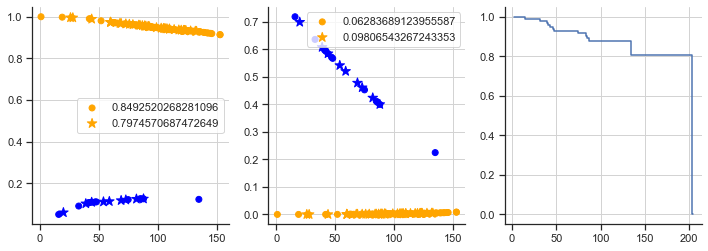

In [172]:
ind_tr = tree.predict(X_tr, target="numb")
ind_HO = tree.predict(X_HO, target="numb")

for k, n in tree.nodes.items():
    if not(n.is_leaf):
        continue
    print(n.get_full_rule())
    flag_ind_tr = ind_tr == k
    flag_ind_HO = ind_HO == k
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].scatter(y_tr[flag_ind_tr]["time"], auprc_by_obs_tr[flag_ind_tr], c=get_color(y_tr[flag_ind_tr]["cens"]), label=np.mean(auprc_by_obs_tr[flag_ind_tr]))
    axes[0].scatter(y_HO[flag_ind_HO]["time"], auprc_by_obs_HO[flag_ind_HO], s=100, marker="*", c=get_color(y_HO[flag_ind_HO]["cens"]), label=np.mean(auprc_by_obs_HO[flag_ind_HO]))
    axes[0].legend()
    
    axes[1].scatter(y_tr[flag_ind_tr]["time"], ibsrm_by_obs_tr[flag_ind_tr], c=get_color(y_tr[flag_ind_tr]["cens"]), label=np.mean(ibsrm_by_obs_tr[flag_ind_tr]))
    axes[1].scatter(y_HO[flag_ind_HO]["time"], ibsrm_by_obs_HO[flag_ind_HO], s=100, marker="*", c=get_color(y_HO[flag_ind_HO]["cens"]), label=np.mean(ibsrm_by_obs_HO[flag_ind_HO]))
    axes[1].legend()
    
    #axes[2].step(bins_HO, pred_surv_tr[flag_ind_tr, :][0])
    axes[2].step(bins_HO, pred_surv[flag_ind_HO, :][0])
    plt.show()

(num_nodes > 4.5) & (num_progesterone > 48.0)


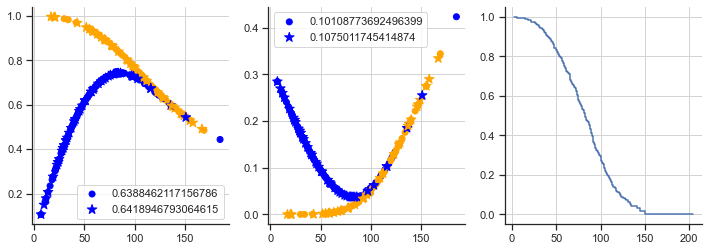

((num_nodes <= 4.5)| nan) & (num_nodes > 1.5) & ((num_estrogen <= 60.0)| nan)


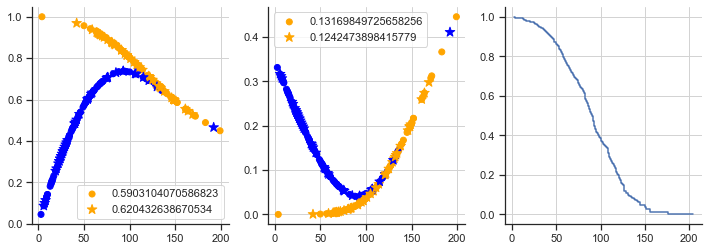

((num_nodes <= 4.5)| nan) & (num_nodes > 1.5) & (num_estrogen > 60.0)


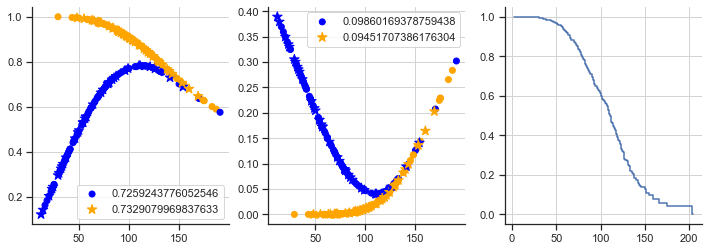

(num_nodes > 4.5) & ((num_progesterone <= 48.0)| nan) & ((num_nodes <= 8.5)| nan)


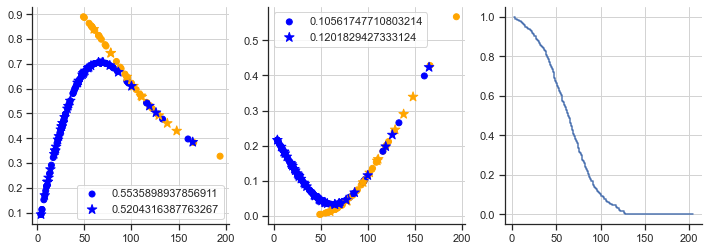

(num_nodes > 4.5) & ((num_progesterone <= 48.0)| nan) & (num_nodes > 8.5)


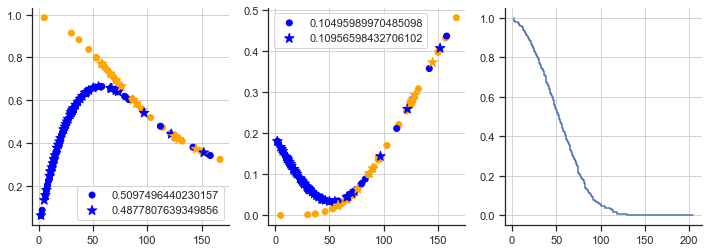

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & (num_age > 66.5) & ((fac_tsize in [0.0])| nan)


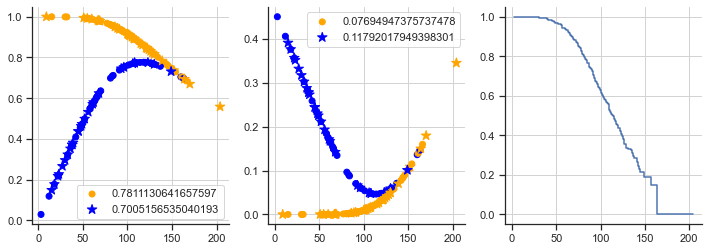

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & (num_age > 66.5) & (fac_tsize in [1.0, 2.0])


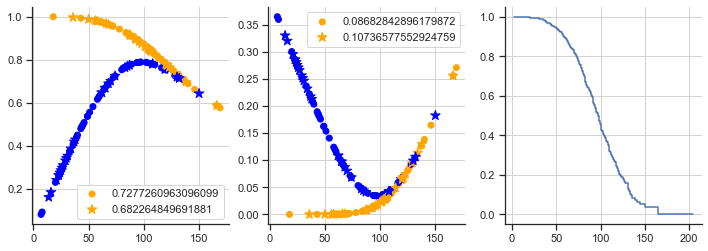

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & ((num_progesterone <= 58.0)| nan) & ((num_year <= 1986.5)| nan)


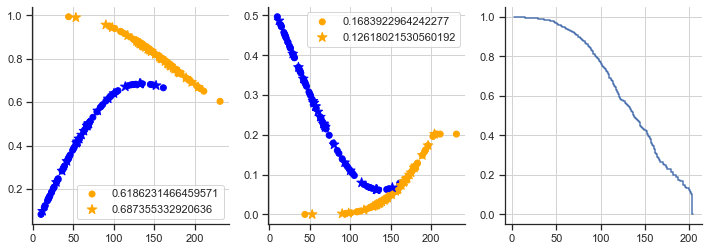

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & (num_progesterone > 58.0) & (fac_tsize in [1.0, 2.0])


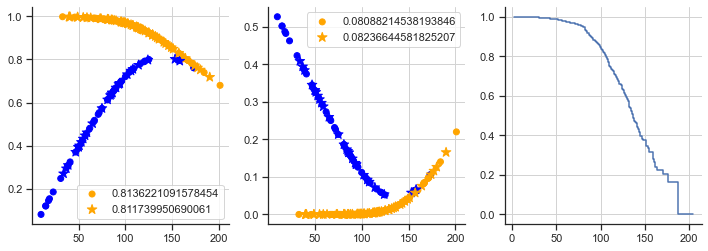

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & ((num_progesterone <= 58.0)| nan) & (num_year > 1986.5) & ((num_age <= 48.5)| nan)


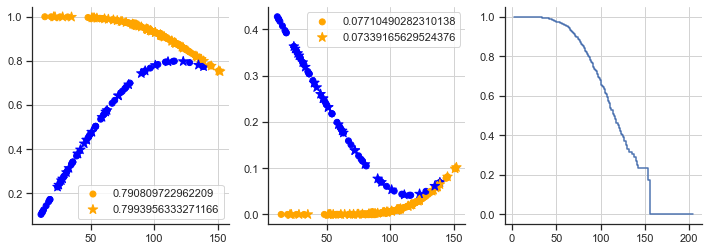

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & (num_progesterone > 58.0) & ((fac_tsize in [0.0])| nan) & ((num_year <= 1988.5)| nan)


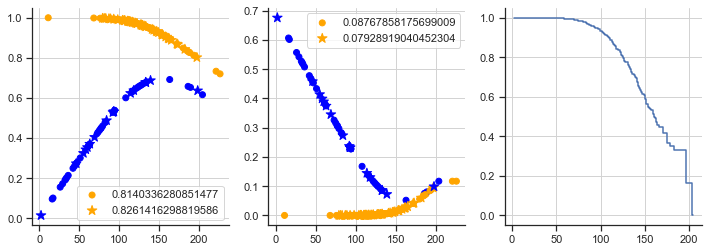

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & (num_progesterone > 58.0) & ((fac_tsize in [0.0])| nan) & (num_year > 1988.5)


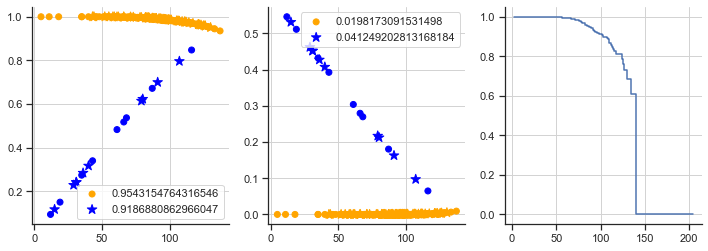

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & ((num_progesterone <= 58.0)| nan) & (num_year > 1986.5) & (num_age > 48.5) & ((num_progesterone <= 4.5)| nan)


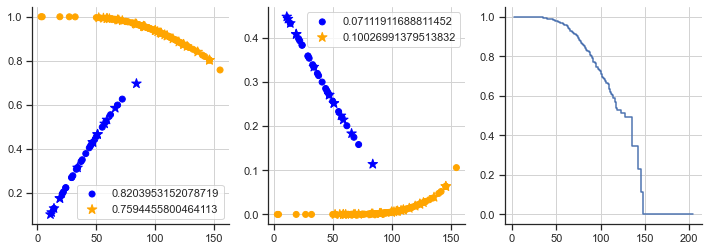

((num_nodes <= 4.5)| nan) & ((num_nodes <= 1.5)| nan) & ((num_age <= 66.5)| nan) & ((num_progesterone <= 58.0)| nan) & (num_year > 1986.5) & (num_age > 48.5) & (num_progesterone > 4.5)


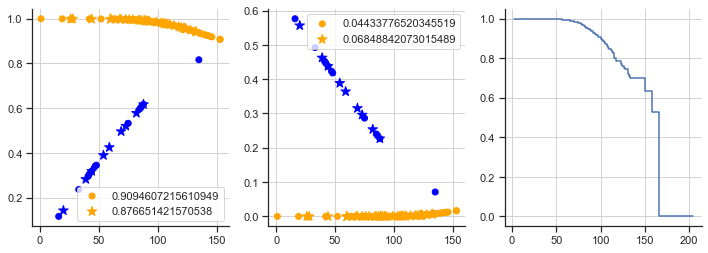

In [ ]:
ind_tr = tree.predict(X_tr, target="numb")
ind_HO = tree.predict(X_HO, target="numb")

for k, n in tree.nodes.items():
    if not(n.is_leaf):
        continue
    print(n.get_full_rule())
    flag_ind_tr = ind_tr == k
    flag_ind_HO = ind_HO == k
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].scatter(y_tr[flag_ind_tr]["time"], auprc_by_obs_tr[flag_ind_tr], c=get_color(y_tr[flag_ind_tr]["cens"]), label=np.mean(auprc_by_obs_tr[flag_ind_tr]))
    axes[0].scatter(y_HO[flag_ind_HO]["time"], auprc_by_obs_HO[flag_ind_HO], s=100, marker="*", c=get_color(y_HO[flag_ind_HO]["cens"]), label=np.mean(auprc_by_obs_HO[flag_ind_HO]))
    axes[0].legend()
    axes[1].scatter(y_tr[flag_ind_tr]["time"], ibsrm_by_obs_tr[flag_ind_tr], c=get_color(y_tr[flag_ind_tr]["cens"]), label=np.mean(ibsrm_by_obs_tr[flag_ind_tr]))
    axes[1].scatter(y_HO[flag_ind_HO]["time"], ibsrm_by_obs_HO[flag_ind_HO], s=100, marker="*", c=get_color(y_HO[flag_ind_HO]["cens"]), label=np.mean(ibsrm_by_obs_HO[flag_ind_HO]))
    axes[1].legend()
    axes[2].step(bins_HO, pred_surv[flag_ind_HO, :][0])
    plt.show()

### Informative censuring comparison

In [4]:
from survivors.external.nonparametric import KaplanMeier

In [5]:
X.shape[0]*0.05, X.shape[0]*0.3

(34.300000000000004, 205.79999999999998)

SF IBS:0.19355, AUPRC:0.58646
SF1 IBS:0.17886, AUPRC:0.69049


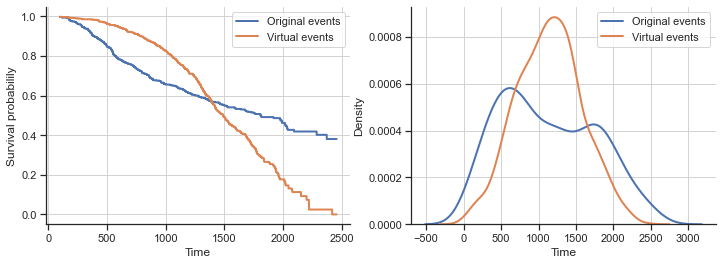

In [6]:
class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfter1(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.normal(np.mean(durations), np.std(durations)/ np.sqrt(2), 1000)  # / np.sqrt(2)
        self.events = np.random.choice(right_censor, size=1000, replace=True)

#         self.durs = np.vstack([np.random.choice(durations, size=1000, replace=True), 
#                                np.random.choice(durations, size=1000, replace=True)]).mean(axis=0)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)
        
        self.events = self.events[self.durs > 0]
        self.durs = self.durs[self.durs > 0]
        
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfter1()
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events")
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events")
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")

In [14]:
y_

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.), ( True,  577.), ( True,  184.),
       (False, 1840.), (False, 1842.), (False, 1821.), ( True, 1371.),
       ( True,  707.), (False, 1743.), (False, 1781.), ( True,  865.),
       ( True, 1684.), (False, 1701.), (False, 1701.), (False, 1693.),
       ( True,  379.), ( True, 1105.), ( True,  548.), ( True, 1296.),
       (False, 1483.), (False, 1570.), (False, 1469.), (False, 1472.),
       (False, 1342.), (False, 1349.), ( True, 1162.), (False, 1342.),
       ( True,  797.), (False, 1232.), (False, 1230.), (False, 1205.),
       (False, 1090.), (False, 1095.), ( True,  449.), (False,  972.),
       (False,  825.), (False, 2438.), (False, 2233.), ( True,  286.),
       (False, 1861.), ( True, 1080.), ( True, 1521.), (False, 1693.),
       ( True, 1528.), ( True,  169.), ( True,  272.), ( True,  731.),
      

In [20]:
X_.shape[0]

686

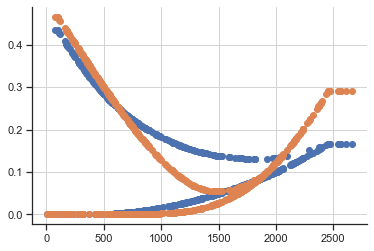

In [32]:
# plt.scatter(y_["time"], metr.ibs(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=0))
# plt.scatter(y_["time"], metr.ibs(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=0))

plt.scatter(y_["time"], metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=0))
plt.scatter(y_["time"], metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=0))

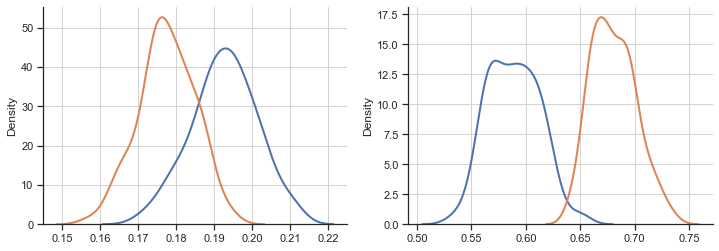

Text(0, 0.5, '$AUPRC$')

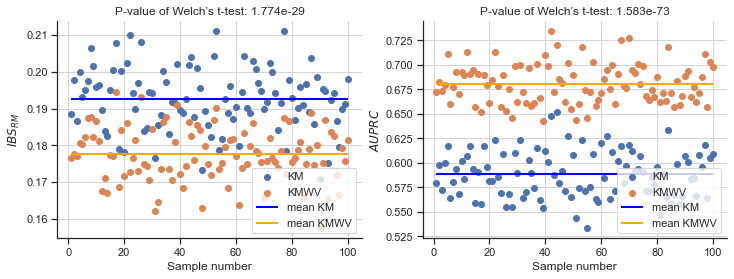

In [32]:
x = np.linspace(1, 100, 100)
ibs_1 = []
ibs_2 = []
auprc_1 = []
auprc_2 = []
np.random.seed(1)

dips = []
for _ in x:
    x_sub = df.sample(n=200, replace=True)
    time = x_sub["time"].to_numpy()
    cens = x_sub["cens"].to_numpy()
    
    #dips.append(diptest.dipstat(time))
    bins_ = cnt.get_bins(time=time)
    y_v = cnt.get_y(cens=cens, time=time)
    
    km = KaplanMeierZeroAfter()
    km.fit(y_v["time"], y_v["cens"])
    sf = km.survival_function_at_times(bins_)

    km1 = KaplanMeierZeroAfter1()
    km1.fit(y_v["time"], y_v["cens"])
    sf1 = km1.survival_function_at_times(bins_)

    ibs_1.append(metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    ibs_2.append(metr.ibs_remain(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

    auprc_1.append(metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    auprc_2.append(metr.auprc(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(ibs_1, ax=axes[0])
sns.kdeplot(ibs_2, ax=axes[0])

sns.kdeplot(auprc_1, ax=axes[1])
sns.kdeplot(auprc_2, ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(x, ibs_1, label="KM")
axes[0].scatter(x, ibs_2, label="KMWV")
axes[0].hlines([np.mean(ibs_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[0].hlines([np.mean(ibs_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[0].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
axes[0].legend()
axes[0].set_xlabel("Sample number")
axes[0].set_ylabel(r"$IBS_{RM}$")

axes[1].scatter(x, auprc_1, label="KM")
axes[1].scatter(x, auprc_2, label="KMWV")
axes[1].hlines([np.mean(auprc_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[1].hlines([np.mean(auprc_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[1].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
axes[1].legend()

axes[1].set_xlabel("Sample number")
axes[1].set_ylabel(r"$AUPRC$")

In [ ]:
def test_normal(sample):
    print("shapiro:", stats.shapiro(sample).pvalue)
    ad = stats.anderson(sample, 'norm')
    print("anderson:", ad.statistic < ad.critical_values[np.where(ad.significance_level == 2.5)][0])
    np.random.seed(42)
    print("kstest:", stats.kstest(sample, 
                       np.random.normal(np.mean(sample), 
                                        np.std(sample), 100000), method="exact").pvalue)
print("ibs_1")
print(np.mean(ibs_1), np.var(ibs_1))
test_normal(ibs_1)
print("ibs_2")
test_normal(ibs_2)
print(np.mean(ibs_2), np.var(ibs_2))

print("auprc_1")
test_normal(auprc_1)
print(np.mean(auprc_1), np.var(auprc_1))
print("auprc_2")
test_normal(auprc_2)
print(np.mean(auprc_2), np.var(auprc_2))

### TREE META COMPARISON